# Data Wrangling, Analysis and Visualisation - Twitter API for WeRateDogs 

In [128]:
# Import the required libraries
import pandas as pd
import numpy as np
import scipy as stats
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import requests
import tweepy
import warnings
import datetime
import time
import json
import sys
import csv
from pandas import Series
from pandas import DataFrame
from tweepy import OAuthHandler
from matplotlib import rcParams
from datetime import datetime,timedelta
from scipy import stats
from timeit import default_timer as timer
from tweepy import OAuthHandler
%matplotlib inline

# Suppress Deprecation and Incorrect Usage Warnings 
import warnings
warnings.filterwarnings('ignore')

In [129]:
#Tweet text max 140 charectors plus 3 for pandas
pd.options.display.max_colwidth = 140

##  Gather

#### Loading data from 'twitter-archive-enhanced.csv'

In [130]:
# Read the csv twitter-archive file uploaded in the Jupyter Notebook Workspace by using Pandas "First Format"
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv', sep = ',')
# display samples of twitter-archive
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1642,684097758874210310,NaN,NaN,2016-01-04 19:43:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Lupe. This is how she sleeps. 10/10 impressive really https://t.co/Fz6iZWlk8C,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684097758874210310/photo/1,10,10,Lupe,None,None,None,None
1519,690735892932222976,NaN,NaN,2016-01-23 03:20:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Peaches. She's a Dingleberry Zanderfloof. 13/10 would caress lots https://t.co/YrhkrTsoTt,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/690735892932222976/photo/1,https://twitter.com/dog_rates/status/690735892932222976/photo/1",13,10,Peaches,None,None,None,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409219559425/photo/1,9,10,Beau,None,None,None,None
700,786233965241827333,NaN,NaN,2016-10-12 15:55:59 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Mattie. She's extremely dangerous. Will bite your h*ckin finger right off. Still 11/10 would pet with caution https://t.co/78c9W...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/786233965241827333/photo/1,11,10,Mattie,None,None,None,None
1019,746790600704425984,NaN,NaN,2016-06-25 19:42:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you just can't resist... 10/10 topnotch tongue https://t.co/jeWEGUgbXf,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/746790600704425984/photo/1,https://twitter.com/dog_rates/status/746790600704425984/photo/1,https://...",10,10,None,None,None,None,None


####  Loading data from 'image-predictions.tsv'

In [131]:
# Download tsv file from the provided url by using requests library "Third format"
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv' 

In [132]:
response = requests.get(url)

# Check whether the specified path is an existing file  
if not os.path.isfile('image-predictions.tsv'):
    with open('image-predictions.tsv' , mode = 'wb') as file:       
        file.write(response.content)   
        
#Extract the file name from the url string (url)
image_predictions = pd.read_csv('image-predictions.tsv', sep='\t')
image_predictions.sample(5)    

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1594,798697898615730177,https://pbs.twimg.com/media/CeRoBaxWEAABi0X.jpg,1,Labrador_retriever,0.868671,True,carton,0.095095,False,pug,0.007651,True
730,686618349602762752,https://pbs.twimg.com/media/CYdbvwjWcAEtjYu.jpg,1,Rottweiler,0.441331,True,miniature_pinscher,0.233180,True,Gordon_setter,0.093582,True
346,672466075045466113,https://pbs.twimg.com/media/CVUUU_EWoAAxABV.jpg,1,cocker_spaniel,0.150424,True,toy_poodle,0.088605,True,Welsh_springer_spaniel,0.072014,True
1748,823581115634085888,https://pbs.twimg.com/media/C23ypm6VQAAO31l.jpg,1,dingo,0.280949,False,German_shepherd,0.194044,True,Pembroke,0.120051,True
1016,709901256215666688,https://pbs.twimg.com/media/CdoTbL_XIAAitq2.jpg,2,bib,0.998814,False,handkerchief,0.000512,False,umbrella,0.000224,False


In [133]:
# Personal API keys, secrets, and tokens have not been included for the project submission as instructed in the Project Details 
consumer_key = '***************************'
consumer_secret = '***************************'
access_token = '***************************'
access_secret = '***************************'

# Other required variables for tweepy query
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

####  Twitter Query using tweet_id information from the df

In [134]:
errors = []
tweet_ids = list(twitter_archive.tweet_id)
tweet_data = {}
if not os.path.isfile('tweet_json.txt'):   
    with open ('tweet_json.txt', 'wb') as file:
        for tweet_id in twitter_archive['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode ='extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)

### creating DataFrame from 'tweet_json.txt' file

In [135]:
# saving required info to the dataframe
api_df = pd.DataFrame(columns=['tweet_ids', 'retweet_count','favorite_count'])

with open('tweet_json.txt') as file:
    for line in file:
        status = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        
        api_df = api_df.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]], 
                                       columns = ['tweet_id', 'retweet_count', 'favorite_count']))
api_df = api_df.reset_index(drop = True)
api_df.sample(10)

,tweet_ids,retweet_count,favorite_count,tweet_id
12,NaN,8538,38818,889665388333682689
1589,NaN,607,2071,686606069955735556
620,NaN,2813,10139,796116448414461957
569,NaN,275,1958,801854953262350336
1189,NaN,670,2660,717841801130979328
1411,NaN,699,2787,698907974262222848
1930,NaN,1360,1914,674024893172875264
1330,NaN,1045,3231,705475953783398401
1495,NaN,265,1618,692423280028966913
772,NaN,10673,0,776249906839351296


# Assess

### twitter_archive prediction


In [136]:
# View info of twitter_archive DataFrame
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [137]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [138]:
# View first 5 rows of twitter_archive DataFrame
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWe...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [139]:
# View last 5 rows of twitter_archive DataFrame
twitter_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


In [140]:
twitter_archive.count()

tweet_id                      2356
in_reply_to_status_id           78
in_reply_to_user_id             78
timestamp                     2356
source                        2356
text                          2356
retweeted_status_id            181
retweeted_status_user_id       181
retweeted_status_timestamp     181
expanded_urls                 2297
rating_numerator              2356
rating_denominator            2356
name                          2356
doggo                         2356
floofer                       2356
pupper                        2356
puppo                         2356
dtype: int64

In [141]:
len(twitter_archive)

2356

In [142]:
twitter_archive.shape

(2356, 17)

In [143]:
twitter_archive.tweet_id.is_unique

True

In [144]:
# Custom function to display only unique column names of a DataFrame

def print_unique_columns(df):
    for column in list(df.columns):
        if df[column].value_counts().count() == len(df):
            print (column)

In [145]:
print_unique_columns(twitter_archive)

tweet_id
timestamp
text


In [146]:
twitter_archive.index

RangeIndex(start=0, stop=2356, step=1)

In [147]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [148]:
# Checking the ratings(numerator) using value_counts 
twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [149]:
#preview of only first 5 value of 'text' column  
for text_ in twitter_archive.text[:5]:
    print(text_+"\n")

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU

This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV

This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB

This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ

This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f



In [150]:
twitter_archive.puppo.value_counts()


None     2326
puppo      30
Name: puppo, dtype: int64

In [151]:
sum(~twitter_archive.puppo.duplicated())

2

In [152]:
sum(twitter_archive.expanded_urls.isnull()) 

59

In [153]:
sum(twitter_archive.expanded_urls.isin([np.nan]))

59

In [154]:
sum(twitter_archive.expanded_urls.str.startswith("http"))

nan

In [155]:
#So it is proven all non NaN entries of the column 'expanded_urls' are actually urls
twitter_archive.shape[0] == 2297+59

True

In [156]:
# 'name' column has 1611 rows with non null values
twitter_archive_non_None = twitter_archive[~twitter_archive.name.isin(['None'])]
twitter_archive_non_None.shape

(1611, 17)

In [157]:
# view duplicated values
sum(twitter_archive_non_None.name.duplicated())

655

In [158]:
twitter_archive_non_None[twitter_archive_non_None.name.duplicated()].name.value_counts().sort_values(ascending=False).head(10)

a          54
Charlie    11
Oliver     10
Lucy       10
Cooper     10
Lola        9
Tucker      9
Penny       9
Bo          8
Winston     8
Name: name, dtype: int64

In [159]:
sum(twitter_archive.expanded_urls.duplicated())

137

In [160]:
# Investigating the rows where text column includes #.#/# indicating a decimal for the rating numerator, 
# however the same value may not appear in the 'rating_numerator' column
twitter_archive[twitter_archive.text.str.contains(r"(\d+\.\d*\/\d+)")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile bac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


In [161]:
# Search for the word/phrase "named" or "name is" in the 'text' column where the value of 'name' is lowercase, as this is an indicator 
# that there is an actual name.
twitter_archive.loc[((twitter_archive['name'].str.islower()) & (twitter_archive['text'].str.contains('named'))) | ((twitter_archive['name'].str.islower()) & (twitter_archive['text'].str.contains('name is')))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
852,765395769549590528,NaN,NaN,2016-08-16 03:52:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765395769549590528/photo/1,13,10,my,None,None,None,None
1853,675706639471788032,NaN,NaN,2015-12-12 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675706639471788032/photo/1,10,10,a,None,None,None,None
1955,673636718965334016,NaN,NaN,2015-12-06 22:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673636718965334016/photo/1,10,10,a,None,None,None,None
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150407421952/photo/1,11,10,a,None,None,None,None
2066,671147085991960577,NaN,NaN,2015-11-30 02:01:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVh...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085991960577/photo/1,9,10,a,None,None,None,None
2116,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002554466305/photo/1,9,10,a,None,None,None,None
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874861563904/photo/1,9,10,a,None,None,None,None
2128,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/yV3Qgjh8iN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360680108032/photo/1,9,10,a,None,None,None,None
2146,669923323644657664,NaN,NaN,2015-11-26 16:59:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a spotted Lipitor Rumpelstiltskin named Alphred. He can't wait for the Turkey. 10/10 would pet really well https://t.co/6GUGO7azNX,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669923323644657664/photo/1,10,10,a,None,None,None,None
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a Coriander Baton Rouge named Alfredo. Loves to cuddle with smaller well-dressed dog. 10/10 would hug lots https:/

In [162]:
# View the row where dog name is 'O', however the 'text' column shows that the dog's name is actually 'O'Malley' 
twitter_archive[twitter_archive.name == "O"]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
775,776201521193218049,NaN,NaN,2016-09-14 23:30:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776201521193218049/photo/1,10,10,O,None,None,None,None


In [163]:
# View rows which contain '&amp;' in 'text' column
twitter_archive[twitter_archive.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
262,842765311967449089,NaN,NaN,2017-03-17 15:51:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Indie. She's not a fan of baths but she's definitely a fan of hide &amp; seek. 12/10 click the link to help Indie\n\nhttps://t.co/f...,NaN,NaN,NaN,"https://www.gofundme.com/get-indie-home/,https://twitter.com/dog_rates/status/842765311967449089/photo/1,https://twitter.com/dog_rates/s...",12,10,Indie,None,None,None,None
273,840728873075638272,NaN,NaN,2017-03-12 00:59:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Pipsy. He is a fluffball. Enjoys traveling the sea &amp; getting tangled in leash. 12/10 I would kill for Pipsy h...,6.671522e+17,4.196984e+09,2015-11-19 01:27:25 +0000,https://twitter.com/dog_rates/status/667152164079423490/photo/1,12,10,Pipsy,None,None,None,None
320,834458053273591808,NaN,NaN,2017-02-22 17:41:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Chester (bottom) &amp; Harold (top). They are different dogs not only in appearance, but in personality as well. Both 12/10 symbiot...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/834458053273591808/photo/1,12,10,Chester,None,None,None,None
461,817536400337801217,NaN,NaN,2017-01-07 01:00:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Say hello to Eugene &amp; Patti Melt. No matter how dysfunctional they get, they will never top their owners. Both 12/10 would pet at sa...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/817536400337801217/photo/1,https://twitter.com/dog_rates/status/817536400337801217/photo/1,https://...",12,10,Eugene,None,None,None,None
485,814578408554463233,NaN,NaN,2016-12-29 21:06:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups ...,6.981954e+17,4.196984e+09,2016-02-12 17:22:12 +0000,https://twitter.com/dog_rates/status/698195409219559425/photo/1,9,10,Beau,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/9...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
799,772826264096874500,NaN,NaN,2016-09-05 15:58:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Roosevelt. He's preparing for takeoff. Make sure tray tables are in their full pupright &amp; licked position\n11/10 https://t.co/7...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772826264096874500/photo/1,11,10,Roosevelt,None,None,None,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MY...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggo,None,pupper,None
898,758854675097526272,NaN,NaN,2016-07-29 02:40:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Lilli Bee &amp; Honey Bear. Unfortunately, they were both born with no eyes. So heckin sad. Both 11/10 https://t.

###  image prediction

In [164]:
image_predictions.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

In [165]:
image_predictions.index

RangeIndex(start=0, stop=2075, step=1)

In [166]:
# View last 5 rows of image_preds DataFrame
image_predictions.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [167]:
# View info of image_preds DataFrame
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [168]:
image_predictions.tweet_id.is_unique

True

In [169]:
image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [170]:
sum(image_predictions.jpg_url.str.startswith("http"))

2075

In [171]:
#all entries of the column 'jpg_url' are actually urls
image_predictions.shape[0] == sum(image_predictions.jpg_url.str.startswith("http"))

True

In [172]:
#If I need to consider only dog pictures, then either imagePredict_df.p1_dog is True or imagePredict_df.p2_dog is True or imagePredict_df.p3_dog is True

tmp = image_predictions[(image_predictions.p1_dog == True) | (image_predictions.p2_dog == True) | (image_predictions.p3_dog == True)]

tmp.shape

(1751, 12)

In [173]:
#tmp DataFrame containing only Dog related tweets
sum((tmp.p1_conf>tmp.p2_conf) & (tmp.p2_conf>tmp.p3_conf))

1751

### api_df `favorite tweets` prediction

In [174]:
# View first 5 rows of api_df DataFrame
api_df.head()

,tweet_ids,retweet_count,favorite_count,tweet_id
0,NaN,8853,39467,892420643555336193
1,NaN,6514,33819,892177421306343426
2,NaN,4328,25461,891815181378084864
3,NaN,8964,42908,891689557279858688
4,NaN,9774,41048,891327558926688256


In [175]:
# View last 5 rows of api_df DataFrame
api_df.tail()

,tweet_ids,retweet_count,favorite_count,tweet_id
2349,NaN,41,111,666049248165822465
2350,NaN,147,311,666044226329800704
2351,NaN,47,128,666033412701032449
2352,NaN,48,132,666029285002620928
2353,NaN,532,2535,666020888022790149


In [176]:
api_df.retweet_count.value_counts(ascending=False).head()

3652    5
83      5
1972    5
146     4
819     4
Name: retweet_count, dtype: int64

In [177]:
api_df.favorite_count.value_counts(ascending=False).head()

0       179
2176      3
610       3
1339      3
2706      3
Name: favorite_count, dtype: int64

In [178]:
# View info of api_df DataFrame
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_ids       0 non-null      object
 1   retweet_count   2354 non-null   object
 2   favorite_count  2354 non-null   object
 3   tweet_id        2354 non-null   object
dtypes: object(4)
memory usage: 73.7+ KB


In [179]:
# describe api_df DataFrame
api_df.describe()

,tweet_ids,retweet_count,favorite_count,tweet_id
count,0,2354,2354,2354
unique,0,1724,2007,2354
top,NaN,3652,0,748575535303884801
freq,NaN,5,179,1


### Quality

#### `twitter-archive table`

- "tweet_id datatype is int64, require str(string)
- type of 'timestamp' and 'retweeted_status_timestamp' are str not Timestamp
- Separate Date and Time from timestamp column and create two new columns.
- As per project description 'doggo' , 'floofer' , 'pupper' & 'puppo' columns have some missing values.
- need to fix consistency issue for 'doggo','floofer','pupper'& 'puppo' columns and then assign NaN , if one of its 
- corresponding column already filled with non null value.
- Remove rows where there are no images.
- Fix rating numerator and denominators that are not actually ratings.
- Fix rating numerator that have decimals.
- Change missing values in 'name' from 'None' to NaN.
- Remove extra characters after '&' in 'text' column.

#### `image-prediction table`
- 'tweet_id' datatype is int64, require str(string)
- A new column 'type' could be created which will represent dog types.

#### ` api_df  table`
* 'retweet_count' & 'favorite_count' column have some missing values : "Not Exist" . Need to get rid of those rows/observations * from the table.
* 'retweet_count' & 'favorite_count' datatype are str(string) , required int64

### Tidiness

`twitter-archive table`
* 'doggo' , 'floofer' , 'pupper' & 'puppo' are stage of dogs,so they should be under 1 column

`image_predictions table`
* image_predictions should have been merged in twitter_archive

`api_df table`
* 'retweet_count' & 'favorite_count' features should be the part of the twitter-archive table
* api_df dataframe should have been merged in twitter_archive

In [180]:
# Create copies of all three gathered DataFrames
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
api_df_clean = api_df.copy()

## `twitter-archive table`

### Cleaning  (Quality Issue 1)
#### Define
* 'tweet_id' datatype is int64, require str(string)
- use astype() to conver datatype of a column

#### Code

In [181]:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype("str")

#### Test

In [182]:
type(twitter_archive_clean.tweet_id.iloc[0])

str

### Cleaning  (Quality Issue 2)
#### Define
* type of 'timestamp' and 'retweeted_status_timestamp' are str not Timestamp
* Use to_datetime method of pandas module to convert appropriate string to Timestamp object.

#### Code

In [183]:
twitter_archive_clean.timestamp = pd.to_datetime(twitter_archive_clean.timestamp)

#### Test

In [184]:
twitter_archive_clean.timestamp.dtype

datetime64[ns, UTC]

### Cleaning  (Quality Issue 3)
#### Define
* Separate Date and Time from timestamp column and create two new columns.
* Use to_datetime method of pandas module to divide it to ['date']&['time']

#### Code

In [185]:
#Use pd.to_datetime to convert the column from strings to DateTime objects.
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

#Using .apply() to create 2 new separate columns called date and time. 

twitter_archive_clean['date'] = twitter_archive_clean['timestamp'].apply(lambda time: time.strftime('%m-%d-%Y'))
twitter_archive_clean['time'] = twitter_archive_clean['timestamp'].apply(lambda time: time.strftime('%H:%M'))

In [186]:
# remove timestamp column from twitter_archive_clean column
twitter_archive_clean.drop(['timestamp'], axis=1, inplace = True) 

#### Test

In [187]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None,08-01-2017,16:23
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None,08-01-2017,00:17
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None,07-31-2017,00:18
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None,07-30-2017,15:58
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWe...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None,07-29-2017,16:00


### Cleaning  (Quality Issue 4)
#### Define
* find doggo' , 'floofer' , 'pupper' & 'puppo' columns have some missing values.
* from 'text' column by .str through regular expression extract()

#### Code

In [188]:
twitter_archive_clean.doggo = None
twitter_archive_clean.doggo = twitter_archive_clean.text.str.extract('\\b(doggo|Doggo)\\b', expand=True)[0]

In [189]:
twitter_archive_clean.puppo = None
twitter_archive_clean.puppo = twitter_archive_clean.text.str.extract('\\b(puppo|Puppo)\\b', expand=True)[0]

In [190]:
twitter_archive_clean.pupper = None
twitter_archive_clean.pupper = twitter_archive_clean.text.str.extract('\\b(pupper|Pupper)\\b', expand=True)[0]

In [191]:
twitter_archive_clean.floofer = None
twitter_archive_clean.floofer = twitter_archive_clean.text.str.extract('\\b(floofer|Floofer)\\b', expand=True)[0]

#### Test

In [192]:
twitter_archive_clean.doggo.value_counts()

doggo    86
Doggo     9
Name: doggo, dtype: int64

In [193]:
twitter_archive_clean.puppo.value_counts()

puppo    29
Name: puppo, dtype: int64

In [194]:
twitter_archive_clean.pupper.value_counts()

pupper    247
Pupper      7
Name: pupper, dtype: int64

In [195]:
twitter_archive_clean.floofer.value_counts()

Floofer    6
floofer    4
Name: floofer, dtype: int64

### Cleaning  (Quality Issue 5)
#### Define
* fix consistency issue for 'doggo','floofer','pupper'& 'puppo' columns and then assign NaN , if one of its corresponding column already filled with non null value.
* use replace() to replace "Doggo" with "doggo",etc. and to assign NaN , use np.nan

#### Code

In [196]:
twitter_archive_clean.doggo.replace("Doggo","doggo",inplace=True)

In [197]:
twitter_archive_clean.floofer[twitter_archive_clean.doggo.notnull()] = np.nan
twitter_archive_clean.floofer.replace("Floofer","floofer",inplace=True)

In [198]:
twitter_archive_clean.pupper[twitter_archive_clean.doggo.notnull() | twitter_archive_clean.floofer.notnull()] = np.nan
twitter_archive_clean.pupper.replace("Pupper","pupper",inplace=True)

In [199]:
twitter_archive_clean.puppo[twitter_archive_clean.doggo.notnull() | twitter_archive_clean.floofer.notnull() | twitter_archive_clean.pupper.notnull()] = np.nan
twitter_archive_clean.puppo.replace("Puppo","puppo",inplace=True)

#### Test

In [200]:
twitter_archive_clean.doggo.value_counts()

doggo    95
Name: doggo, dtype: int64

In [201]:
twitter_archive_clean.floofer.value_counts()

floofer    9
Name: floofer, dtype: int64

In [202]:
twitter_archive_clean.pupper.value_counts()

pupper    243
Name: pupper, dtype: int64

In [203]:
twitter_archive_clean.puppo.value_counts()

puppo    28
Name: puppo, dtype: int64

### Cleaning  (Quality Issue 6)
#### Define
* Remove rows where there are no images.

#### Code

In [204]:
twitter_archive_clean = twitter_archive_clean.dropna(subset=['expanded_urls'])

#### Test

In [205]:
sum(twitter_archive_clean['expanded_urls'].isnull())

0

### Cleaning  (Quality Issue 7)
#### Define
* Fix rating numerator and denominators that are not actually ratings.

#### Code

In [206]:
# View all occurences where there are more than one #/# in 'text' column
twitter_archive_clean[twitter_archive_clean.text.str.contains( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
561,802624713319034886,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,"https://twitter.com/dog_rates/status/777684233540206592/photo/1,https://twitter.com/dog_rates/status/777684233540206592/photo/1",12,10,None,NaN,NaN,NaN,NaN,11-26-2016,21:26
766,777684233540206592,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233540206592/photo/1,12,10,None,NaN,NaN,NaN,NaN,09-19-2016,01:42
784,775096608509886464,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP http...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://...",9,11,None,NaN,NaN,NaN,NaN,09-11-2016,22:20
860,763167063695355904,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) http...,6.732953e+17,4.196984e+09,2015-12-06 00:17:55 +0000,https://twitter.com/dog_rates/status/673295268553605120/photo/1,8,10,Eve,NaN,NaN,pupper,NaN,08-10-2016,00:16
1007,747600769478692864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/747600769478692864/photo/1,https://twitter.com/dog_rates/status/747600769478692864/photo/1",10,10,Bookstore,NaN,NaN,NaN,NaN,06-28-2016,01:21
1068,740373189193256964,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDND...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://...",9,11,None,NaN,NaN,NaN,NaN,06-08-2016,02:41
1165,722974582966214656,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,NaN,NaN,NaN,NaN,04-21-2016,02:25
1202,716439118184652801,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,NaN,NaN,NaN,NaN,04-03-2016,01:36
1222,714258258790387713,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Ak...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714258258790387713/photo/1,10,10,Travis,NaN,NaN,NaN,NaN,03-28-2016,01:10
1359,703356393781329922,NaN,NaN,"<a href=""http://twitter.c

In [207]:
# Save the text where the rating numerator and denominators were incorrectly extracted
ratings_to_fix = ['After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ', 
 'Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a', 
 'This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq', 
 'This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5',
 'This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv']

In [208]:
# Loop through the list of ratings to fix and extract the second occurence of #/ to save as the rating numerator. As all the
# occurences of the actual ratings in the ratings to fix list have a denominator of 10, we will set that value for each 
#entry instead of extracting it.
for entry in ratings_to_fix:
    mask = twitter_archive_clean.text == entry
    column_name1 = 'rating_numerator'
    column_name2 = 'rating_denominator'
    twitter_archive_clean.loc[mask, column_name1] = re.findall(r"\d+\.?\d*\/\d+\.?\d*\D+(\d+\.?\d*)\/\d+\.?\d*", entry)
    twitter_archive_clean.loc[mask, column_name2] = 10

#### Test

In [209]:
twitter_archive_clean[twitter_archive_clean.text.isin(ratings_to_fix)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
1068,740373189193256964,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDND...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://...",14,10,None,NaN,NaN,NaN,NaN,06-08-2016,02:41
1165,722974582966214656,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582966214656/photo/1,13,10,None,NaN,NaN,NaN,NaN,04-21-2016,02:25
1202,716439118184652801,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118184652801/photo/1,11,10,Bluebert,NaN,NaN,NaN,NaN,04-03-2016,01:36
1662,682962037429899265,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/682962037429899265/photo/1,10,10,Darrel,NaN,NaN,NaN,NaN,01-01-2016,16:30
2335,666287406224695296,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,9,10,an,NaN,NaN,NaN,NaN,11-16-2015,16:11


### Cleaning  (Quality Issue 8)
#### Define
* Fix rating numerator that have decimals.

#### Code

In [210]:
# View tweets with decimals in rating in 'text' column
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
45,883482846933004288,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,NaN,NaN,NaN,NaN,07-08-2017,00:28
340,832215909146226688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,NaN,NaN,NaN,NaN,02-16-2017,13:11
695,786709082849828864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,NaN,NaN,NaN,NaN,10-13-2016,23:23
763,778027034220126208,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile bac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,NaN,NaN,pupper,NaN,09-20-2016,00:24
1712,680494726643068929,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,NaN,NaN,NaN,NaN,12-25-2015,21:06


In [211]:
# Change datatype of rating_numerator and denominator to float
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].astype('float')
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].astype('float')

In [212]:
# Set correct numerators for specific tweets
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 883482846933004288) & (twitter_archive_clean['rating_numerator'] == 5), ['rating_numerator']] = 13.5
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 786709082849828864) & (twitter_archive_clean['rating_numerator'] == 75), ['rating_numerator']] = 9.75
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 778027034220126208) & (twitter_archive_clean['rating_numerator'] == 27), ['rating_numerator']] = 11.27
twitter_archive_clean.loc[(twitter_archive_clean['tweet_id'] == 680494726643068929) & (twitter_archive_clean['rating_numerator'] == 26), ['rating_numerator']] = 11.26

#### Test

In [213]:
twitter_archive_clean[twitter_archive_clean.text.str.contains(r"(\d+\.\d*\/\d+)")]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time
45,883482846933004288,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5.0,10.0,Bella,NaN,NaN,NaN,NaN,07-08-2017,00:28
340,832215909146226688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75.0,10.0,Logan,NaN,NaN,NaN,NaN,02-16-2017,13:11
695,786709082849828864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75.0,10.0,Logan,NaN,NaN,NaN,NaN,10-13-2016,23:23
763,778027034220126208,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile bac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27.0,10.0,Sophie,NaN,NaN,pupper,NaN,09-20-2016,00:24
1712,680494726643068929,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26.0,10.0,None,NaN,NaN,NaN,NaN,12-25-2015,21:06


### Cleaning  (Quality Issue 9)
#### Define
* Change missing values in 'name' from 'None' to NaN.

#### Code

In [214]:
twitter_archive_clean['name'] = twitter_archive_clean['name'].replace('None', np.NaN)

#### Test

In [215]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2297 non-null   object 
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   source                      2297 non-null   object 
 4   text                        2297 non-null   object 
 5   retweeted_status_id         180 non-null    float64
 6   retweeted_status_user_id    180 non-null    float64
 7   retweeted_status_timestamp  180 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2297 non-null   float64
 10  rating_denominator          2297 non-null   float64
 11  name                        1611 non-null   object 
 12  doggo                       92 non-null     object 
 13  floofer                     9 non

### Cleaning  (Quality Issue 10)
#### Define
* Remove extra characters after '&' in 'text' column.

#### Code

In [216]:
twitter_archive_clean['text'] = twitter_archive_clean['text'].str.replace('&amp;', '&')

#### Test

In [217]:
twitter_archive_clean[twitter_archive_clean.text.str.contains('&amp;')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,date,time


## `image_prediction table`

### Cleaning  (Quality Issue 11)
#### Define
* 'tweet_id' datatype is int64, require str(string)column already filled with non null value.
* use astype() to conver datatype of a column


#### Code

In [218]:
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype("str")

#### Test

In [219]:
image_predictions_clean.tweet_id.dtype

dtype('O')

### Cleaning  (Quality Issue 12)
#### Define
* A new column 'type' could be created which will represent dog types

#### Code

In [220]:
image_predictions_clean["type"] = None

In [221]:
image_predictions_clean.type[image_predictions_clean.p1_dog == True] \
= image_predictions_clean[image_predictions_clean.p1_dog == True].p1

In [222]:
image_predictions_clean.type.fillna("mix",inplace=True)

#### Test

In [223]:
image_predictions_clean.type.value_counts()

mix                   543
golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
                     ... 
groenendael             1
Japanese_spaniel        1
standard_schnauzer      1
EntleBucher             1
silky_terrier           1
Name: type, Length: 112, dtype: int64

In [224]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True,Welsh_springer_spaniel
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,redbone
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,German_shepherd
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,Rhodesian_ridgeback
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,miniature_pinscher


## `api_df table`

### Cleaning  (Quality Issue 13)
#### Define
* get rid of missing rows/observations from the table for column names : 'retweet_count' & 'favorite_count
* Use isin() for filtering out missing values("Not Exist") from each cloumn


#### Code

In [225]:
api_df_clean = api_df_clean[~api_df_clean.retweet_count.isin(["Not Exist"])]

In [226]:
api_df_clean = api_df_clean[~api_df_clean.favorite_count.isin(["Not Exist"])]

#### Test

In [227]:
sum(api_df_clean.favorite_count.isin(["Not Exist"]))

0

In [228]:
sum(api_df_clean.retweet_count.isin(["Not Exist"]))

0

### Cleaning  (Quality Issue 14)
#### Define
* 'retweet_count' & 'favorite_count' datatype are str(string) , required int64
* Use .astype() to change the datatype of the column to int64 from str.


#### Code

In [229]:
api_df_clean.retweet_count = api_df_clean.retweet_count.astype("int64")

In [230]:
api_df_clean.favorite_count = api_df_clean.favorite_count.astype("int64")

#### Test

In [231]:
api_df_clean.retweet_count.dtype

dtype('int64')

In [232]:
api_df_clean.favorite_count.dtype

dtype('int64')

## `Tidiness`

### Cleaning  (Tideness Issue  1)
#### Define
* 'doggo' , 'floofer' , 'pupper' & 'puppo' are stage of dogs,so they should be under 1 column
* Create a new column called : dog_stage And assign it with any non null value of 'doggo' or 'floofer' or 'pupper' or 'puppo' columns. And null values should be filled with NaN. After that drop 'doggo' , 'floofer' , 'pupper' & 'puppo' columns


#### Code

In [233]:
twitter_archive_clean["dog_stage"] = (twitter_archive_clean.doggo.fillna("")+
                                    twitter_archive_clean.floofer.fillna("")+
                                    twitter_archive_clean.pupper.fillna("")+
                                    twitter_archive_clean.puppo.fillna(""))

In [234]:
twitter_archive_clean["dog_stage"] = twitter_archive_clean["dog_stage"].replace("",np.nan)

In [235]:
#Dropping columns
twitter_archive_clean.drop("doggo",axis=1,inplace=True)
twitter_archive_clean.drop("floofer",axis=1,inplace=True)
twitter_archive_clean.drop("pupper",axis=1,inplace=True)
twitter_archive_clean.drop("puppo",axis=1,inplace=True)

In [236]:
# handle multiple stages
#Either have the 'multiple' , or simply use the comma as another stage.
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

#### Test

In [237]:
twitter_archive_clean.head(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,date,time,dog_stage
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,10.0,Phineas,08-01-2017,16:23,NaN
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,10.0,Tilly,08-01-2017,00:17,NaN
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,10.0,Archie,07-31-2017,00:18,NaN
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,10.0,Darla,07-30-2017,15:58,NaN
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWe...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,10.0,Franklin,07-29-2017,16:00,NaN
5,891087950875897856,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950875897856/photo/1,13.0,10.0,NaN,07-29-2017,00:08,NaN
6,890971913173991426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4h...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",13.0,10.0,Jax,07-28-2017,16:27,NaN
7,890729181411237888,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nO...,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",13.0,10.0,NaN,07-28-2017,00:22,NaN
8,890609185150312448,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185150312448/photo/1,13.0,10.0,Zoey,07-27-2017,16:25,NaN
9,890240255349198849,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate ht...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255349198849/photo/1

In [238]:
twitter_archive_clean["dog_stage"].value_counts()

pupper     241
doggo       92
puppo       27
floofer      9
Name: dog_stage, dtype: int64

### Cleaning  (Tideness Issue 2)
#### Define
* column name 'retweet_count' & 'favorite_count' should be part of the twiter-archive table
* Use .merge() function of the DataFrame to join other DataFrame. It would be a inner join.
* After joining done, api_df table would not be of any usage.

#### Code

In [239]:
twitter_archive_clean = twitter_archive_clean.merge(api_df_clean,on="tweet_id")

In [240]:
twitter_archive_clean = twitter_archive_clean.merge(image_predictions_clean,on="tweet_id")

#### Test

In [241]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
0,892420643555336193,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13.0,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,mix
1,892177421306343426,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13.0,...,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,Chihuahua
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Chihuahua
3,891689557279858688,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13.0,...,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,mix
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWe...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,basset


## Store the final dataset `twitter_archive_master` 

In [242]:
# coping data from final cleaned copy of 'twitter-archive' table to twitter_archive_master DataFrame
twitter_archive_master = twitter_archive_clean

In [243]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2073 non-null   object 
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   source                      2073 non-null   object 
 4   text                        2073 non-null   object 
 5   retweeted_status_id         79 non-null     float64
 6   retweeted_status_user_id    79 non-null     float64
 7   retweeted_status_timestamp  79 non-null     object 
 8   expanded_urls               2073 non-null   object 
 9   rating_numerator            2073 non-null   float64
 10  rating_denominator          2073 non-null   float64
 11  name                        1496 non-null   object 
 12  date                        2073 non-null   object 
 13  time                        2073 

In [244]:
# Create a folder to store files inside
folder = 'Stored_Clean_Data'
if not os.path.exists(folder):
    os.makedirs(folder)
twitter_archive_clean.to_csv('Stored_Clean_Data/twitter_archive_enhanced_clean.csv', index = False)
image_predictions_clean.to_csv('Stored_Clean_Data/image_predictions_clean.csv' , index = False)
api_df_clean.to_csv('Stored_Clean_Data/tweet_json_clean.csv' , index = False)

##  Analysis

### `insights`

In [245]:
twitter_archive_master.groupby(['dog_stage' , 'type'])['retweet_count','favorite_count'].mean()

retweet_count  favorite_count
dog_stage type                                                   
doggo     Bedlington_terrier              1908.50          9051.0
          Blenheim_spaniel                1104.00          4228.0
          Border_collie                   2506.00          9390.0
          Chesapeake_Bay_retriever        4376.00         12376.0
          Chihuahua                       3327.00         16476.0
...                                           ...             ...
puppo     chow                            1759.00          5575.0
          golden_retriever                2012.50         17417.5
          malamute                        1366.00          4624.0
          miniature_pinscher              3220.00         11203.0
          mix                             5861.25         12737.5

[118 rows x 2 columns]

In [246]:
twitter_archive_master.groupby(["dog_stage","type"])['retweet_count','favorite_count'].mean().max()

retweet_count      52360.0
favorite_count    132810.0
dtype: float64

- 'favorite_count' has the highest mean value than 'retweet_count'

In [247]:
twitter_archive_master.groupby(["dog_stage","type"])['retweet_count','favorite_count'].mean().idxmax()

retweet_count           (doggo, Eskimo_dog)
favorite_count    (puppo, Lakeland_terrier)
dtype: object

- dog_stage : doggo & Dog type : Eskimo_dog has the highest mean value for 'retweet_count'

In [248]:
twitter_archive_master.describe()

,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,2.300000e+01,2.300000e+01,7.900000e+01,7.900000e+01,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2.073000e+03,2.073000e+03
mean,6.978112e+17,4.196984e+09,7.663364e+17,9.967874e+15,12.259045,10.490593,2976.089243,8556.718283,1.203570,0.594532,1.346665e-01,6.034005e-02
std,4.359384e+16,0.000000e+00,5.882530e+16,8.859637e+16,40.690220,7.122415,5054.897526,12098.640994,0.561856,0.271234,1.006830e-01,5.092769e-02
min,6.671522e+17,4.196984e+09,6.675094e+17,7.832140e+05,0.000000,7.000000,16.000000,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.732411e+17,4.196984e+09,7.124037e+17,4.196984e+09,10.000000,10.000000,634.000000,1674.000000,1.000000,0.364095,5.390140e-02,1.619920e-02
50%,6.757073e+17,4.196984e+09,7.798343e+17,4.196984e+09,11.000000,10.000000,1408.000000,3864.000000,1.000000,0.588230,1.186220e-01,4.947150e-02
75%,7.031489e+17,4.196984e+09,8.068680e+17,4.196984e+09,12.000000,10.000000,3443.000000,10937.000000,1.000000,0.843911,1.955730e-01,9.193000e-02
max,8.558181e+17,4.196984e+09,8.768508e+17,7.874618e+17,1776.000000,170.000000,79515.000000,132810.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


- n'rating_denominator' = 10.0
- median of 'retweet_count' = 1408 and median of 'favorite_count'= 3864.
- Maximum 'rating_numerator' = 2073 and minimum 'rating_numerator' is 0

#### `Most rating_numerator Dog`

In [249]:
# The highest rating_numerator 
twitter_archive_master[twitter_archive_master['rating_numerator']==1776]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
802,749981277374128128,NaN,NaN,"<a href=""https://about.twitter.com/products/tweetdeck"" rel=""nofollow"">TweetDeck</a>",This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749981277374128128/photo/1,1776.0,...,bow_tie,0.533941,False,sunglasses,0.080822,False,sunglass,0.050776,False,mix


In [250]:
# Favorite Tweet
api_df_clean.sort_values('favorite_count', ascending=False)[['tweet_id','favorite_count']].head()

,tweet_id,favorite_count
412,822872901745569793,132810
1037,744234799360020481,131075
65,879415818425184262,107956
533,807106840509214720,107015
134,866450705531457537,106827


#### `Most favorite Dog`

In [251]:
# Now, Let's look into the maximun value for favorite count.
twitter_archive_master[twitter_archive_master['favorite_count']== 132810] 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
329,822872901745569793,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a super supportive puppo participating in the Toronto #WomensMarch today. 13/10 https://t.co/nTz3FtorBc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/822872901745569793/photo/1,13.0,...,Lakeland_terrier,0.196015,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,Lakeland_terrier


In [252]:
# Highest retweet
api_df_clean.sort_values('retweet_count', ascending=False)[['tweet_id','retweet_count']].head()

,tweet_id,retweet_count
1037,744234799360020481,79515
259,842892208864923648,56625
533,807106840509214720,56625
816,770743923962707968,52360
1077,739238157791694849,52360


#### `Most retweet Dog`

In [253]:
# Now, Let's look into the maximun value for favorite count.
twitter_archive_master[twitter_archive_master['retweet_count']== 79515] 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
851,744234799360020481,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,NaN,NaN,NaN,https://twitter.com/dog_rates/status/744234799360020481/video/1,13.0,...,Labrador_retriever,0.825333,True,ice_bear,0.044681,False,whippet,0.018442,True,Labrador_retriever


## Visulizations

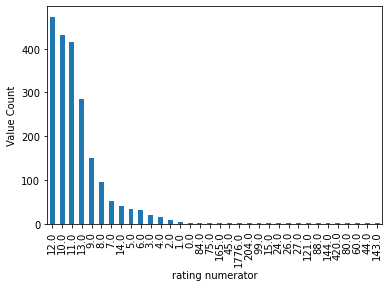

In [254]:
twitter_archive_master.rating_numerator.value_counts().plot(kind="bar" ,title = "")
plt.xlabel('rating numerator')
plt.ylabel('Value Count')
plt.savefig('rating_numerator.png')
plt.show()

In [255]:
# Let's investigate the rating_numerator outlier.
twitter_archive_master[twitter_archive_master['rating_numerator']==12]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type
2,891815181378084864,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/w...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12.0,...,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,Chihuahua
4,891327558926688256,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWe...",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12.0,...,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,basset
13,889638837579907072,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Ted. He does his best. Sometimes that's not enough. But it's ok. 12/10 would assist https://t.co/f8dEDcrKSR,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/889638837579907072/photo/1,https://twitter.com/dog_rates/status/889638837579907072/photo/1",12.0,...,French_bulldog,0.991650,True,boxer,0.002129,True,Staffordshire_bullterrier,0.001498,True,French_bulldog
16,888917238123831296,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jim. He found a fren. Taught him how to sit like the good boys. 12/10 for both https://t.co/chxruIOUJN,NaN,NaN,NaN,https://twitter.com/dog_rates/status/888917238123831296/photo/1,12.0,...,golden_retriever,0.714719,True,Tibetan_mastiff,0.120184,True,Labrador_retriever,0.105506,True,golden_retriever
19,888078434458587136,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Gerald. He was just told he didn't get the job he interviewed for. A h*ckin injustice. 12/10 didn't want the job anyway https://...,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/888078434458587136/photo/1,https://twitter.com/dog_rates/status/888078434458587136/photo/1",12.0,...,French_bulldog,0.995026,True,pug,0.000932,True,bull_mastiff,0.000903,True,French_bulldog
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002,667192066997374976,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",*takes several long deep breaths* omg omg oMG OMG OMG OMGSJYBSNDUYWJO 12/10 https://t.co/QCugm5ydl6,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667192066997374976/photo/1,12.0,...,Rottweiler,0.283640,True,miniature_pinscher,0.148112,True,black-and-tan_coonhound,0.095585,True,Rottweiler
2011,667152164079423490,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pipsy. He is a fluffball. Enjoys traveling the sea & getting tangled in leash. 12/10 I would kill for Pipsy https://t.co/h9R0EwKd9X,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667152164079423490/photo/1,12.0,...,toy_poodle,0.535411,True,Pomeranian,0.087544,True,miniature_poodle,0.062050,True,toy_poodle
2018,667044094246576128,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12/10 gimme now https://t.co/QZAnwgnOMB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667044094246576128/photo/1,12.0,...,golden_retriever,0.765266,True,Labrador_retriever,0.206694,True,seat_belt,0.010667,False,golden_retriever
2024,666826780179869698,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",12/10 si

In [256]:
twitter_archive_master.set_index('date', inplace=True)

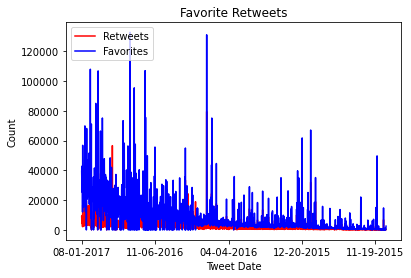

In [257]:
# retweets_favorites visualization
twitter_archive_master['retweet_count'].plot(color = 'red', label='Retweets')
twitter_archive_master['favorite_count'].plot(color = 'blue', label='Favorites')

plt.legend(loc='upper left')
plt.xlabel('Tweet Date')
plt.ylabel('Count')
plt.title('Favorite Retweets')
plt.savefig('retweets_favorites.png')
plt.show()

- from the Histogram we can say, that 'favorite_count' has a maximum count than retweet_count
- Also we see that 'favorite_count' has a high rate racently